In [ ]:
# Dataset
from utils.modules_pbashivan import load_bashivan_data
#from utils.modules_pbashivan import get_subject_indices

import numpy as np
import random

# Dataset and Dataloader
from torch.utils.data import TensorDataset, DataLoader

#from utils.utils import split_losocv

# Save arguments
import argparse

# Torch libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#Model
from models.model_base import RecResNet

#Sklearn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import warnings

warnings.simplefilter("ignore")

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--dir_pretrain', type=str, default="outputs/recresnet", help='folder used by DNN')
parser.add_argument('--dir_resume', type=str, default="outputs/resume", help='folder for resume')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--epochs', type=int, default=30, help='number of epochs')
parser.add_argument('--seed', type=int, default=223, help='seed')
args = parser.parse_args("")

In [ ]:
# set random seeds
np.random.seed(args.seed)
random.seed(args.seed)
#tf.set_random_seed(args.seed)
print("SEED:", args.seed)

In [ ]:
path = '/Dataset/'

In [ ]:
# load data
X, y, subjects = load_bashivan_data(path,
                        n_channels=64, n_windows=7, n_bands=3, generate_images=False,
                        size_image=32, visualize=False)


# Train

## Evaluation function

In [ ]:
def test(model, test_loader):
    start_test = True
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            # get batch data
            samples = data[0].float().cuda()
            labels = data[1].long().cuda()

            # Get features and predictions
            preds = model(samples)
            # probabilidad máxima
            predictions = preds.data.max(1)[1]

            if start_test:
                y_pred = predictions.cpu().numpy()
                y_true = labels.data.cpu().numpy()
                start_test = False
            else:
                y_pred = np.concatenate((y_pred, predictions.cpu().numpy()), 0)
                y_true = np.concatenate((y_true, labels.data.cpu().numpy()), 0)

        # Binarize ytest with shape (n_samples, n_classes)
        labels = np.unique(y_true)
        ytest = label_binarize(y_true, classes=labels)
        ypreds = label_binarize(y_pred, classes=labels)

        # compute utils
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        auc = roc_auc_score(ytest, ypreds, average='macro', multi_class='ovr')


    return acc, f1, auc

### Leave One-Subject-Out Cross-Validation

Es como K-fold cross validation considerando k= n y n es el total del dataset, por lo que se toma como validación cada sujeto en cada iteración

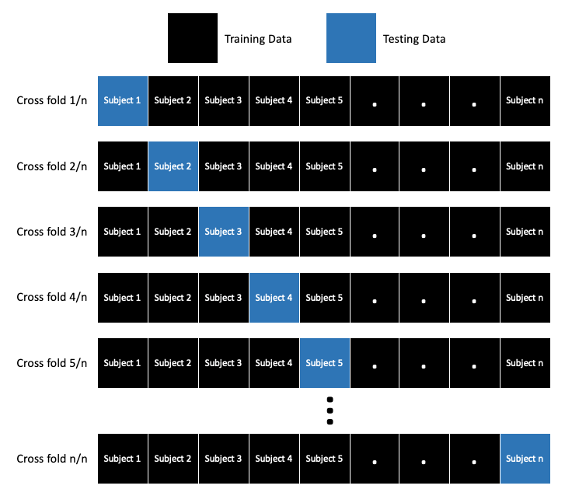

In [ ]:
def split_losocv(X, y, indices):
    """
    Receives the the indices for train and test datasets.
    Outputs the train, validation, and test data and label datasets.
    """

    # get indices to train and test sets
    train_indices = indices[0]
    test_indices = indices[1]

    # obtains train and test sets
    x_train = X[train_indices]
    y_train = np.squeeze(y[train_indices]).astype(np.int32)

    x_test = X[test_indices]
    y_test = np.squeeze(y[test_indices]).astype(np.int32)

    # get list of classes
    y_classes = np.unique(y_train)

    return [(x_train, y_train),
            (x_test, y_test),
            y_classes]


## Extract pairs between indexes and subjects

In [ ]:
def get_subject_indices(domains):
    """
    En tr se almacenan 12 sujetos de entrenamiento y en ts se almacena el sujeto de prueba.
    """

    fold_pairs = []

    for i in np.unique(domains):
        # print(i)
        ts = domains == i  # return array with True where the index i is equal to indices in subjNumbers
        tr = np.squeeze(np.nonzero(np.bitwise_not
            (ts)))  # first return array with Trues where the index i is equal to indices in subjNumbers but inverted
        # after convert this array of numbers.
        ts = np.squeeze(np.nonzero(ts))  # conver ts with trues to array with numbers

        np.random.shuffle(tr)       # Shuffle indices
        np.random.shuffle(ts)
        fold_pairs.append((tr, ts))


    return fold_pairs

In [ ]:
def losocv(X, Y, subjects, args):
    """
        Leave One-Subject-Out Cross-Validation (LOOCV) on Cognitive Load data

        Params
            X: dataset containing all subject samples
            Y: dataset containing all subject labels
            subjects: dataset containing pairs between sample indexes and subjects
            args: hyper-parameters to train Custom Domain Adaptation.
    """

    # variable used to save accuracy results
    list_metrics_clsf = []
        
    # Extract pairs between indexes and subjects
    fold_pairs = get_subject_indices(subjects)
    
    # Iterate over fold_pairs
    for foldNum, fold in enumerate(fold_pairs):
        print('Beginning fold {0} out of {1}'.format(foldNum+1, len(fold_pairs)))
        
        # Divide dataset into training, validation and testing sets
        (x_train, y_train), (x_test, y_test), y_classes = split_losocv(X, Y, fold)

        # data shape
        print("x_train-shape:", x_train.shape, "y_train-shape:", y_train.shape)
        print("x_test-shape:", x_test.shape, "y_test-shape:", y_test.shape)
        print("classes:", y_classes)

        # [NUMPY TO TENSOR]
        Sx_tensor = torch.tensor(x_train)
        Sy_tensor = torch.tensor(y_train)
        Tx_tensor = torch.tensor(x_test)
        Ty_tensor = torch.tensor(y_test)

        # [CONTAINERS]
        # create container for source labeled data
        source = TensorDataset(Sx_tensor, Sy_tensor)
        # create container for labeled target data
        target = TensorDataset(Tx_tensor, Ty_tensor)

        # [BUILD DATA LOADERS]
        # target
        source_loader = DataLoader(source, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
        target_loader = DataLoader(target, batch_size=args.batch_size, shuffle=False, num_workers=4)

        # [Build Model]
        model = RecResNet(n_classes=4).cuda()

        # [Optimizers]
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=0.005)
        # [Classification loss]
        criterion = nn.CrossEntropyLoss().cuda()

        for epoch in range(args.epochs):

            # iterator
            iter_train = iter(source_loader)
            list_loss = []

            for c in range(len(source_loader)):
                # get batch
                samples, labels = next(iter_train)
                samples = samples.float().cuda()
                labels = labels.long().cuda()

                model.train(True)

                # get features and labels for source and target domain
                outputs = model(samples)
                cls_loss = criterion(outputs, labels)

                # reset gradients
                optimizer.zero_grad()
                model.zero_grad()

                # compute gradients
                cls_loss.backward()

                # update weights
                optimizer.step()

                # append loss
                list_loss.append(cls_loss.cpu().detach().numpy())

            # evaluation
            model.eval()

            # [DFN | CNN]
            acc_test, f1_test, auc_test = test(model, target_loader)
            avg_loss = np.array(list_loss).mean()
            print('Epoch: %d loss: %4f Acc: %.4f  F1-score: %.4f  AUC: %.4f' % (epoch+1, avg_loss, acc_test, f1_test, auc_test))
            
        print('Saving model...')
        torch.save(model.state_dict(), 'trained_model/source' + str(foldNum+1) + '.pt')


        print("\n")
        # add to list
        list_metrics_clsf.append([acc_test, f1_test, auc_test, foldNum+1])
    
    # To np array
    list_metrics_clsf = np.array(list_metrics_clsf)

    # Save Classification Metrics
    save_file = args.dir_resume+"/losocv-results.csv"
    f=open(save_file, 'ab')
    np.savetxt(f, list_metrics_clsf, delimiter=",", fmt='%0.4f')
    f.close()

In [ ]:
# run Leave One-Subject-Out Cross-Validation (LOSOCV).
losocv(X, y, subjects, args)

## Open results in csv

In [ ]:
import pandas as pd

df = pd.read_csv(args.dir_resume + "/losocv-results.csv")
print(df.to_string()) 